In [1]:
# @title Mount GDrive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install rasterio numpy xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 44.9 MB/s eta 0:00:00


In [ ]:
# @title Create excel with file names

import os
import pandas as pd

def write_tif_filenames_to_excel(folder_path, excel_path):
    # Get list of all .tif files
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.tif')]

    # Create a DataFrame
    df = pd.DataFrame(tif_files, columns=['Filename'])

    # Save to Excel
    df.to_excel(excel_path, index=False)
    print(f"Excel file created at: {excel_path}")

# Example usage:
folder_path = "/content/drive/My Drive/PAPER3_data/results/final_pred_maps/kalahari_sentinel_4800/2025-03-16-14-49_paper-3-all_OhbV_duneminds_exp"
excel_path = "/content/drive/My Drive/PAPER3_data/results/final_pred_maps/final_pred_maps_CHOICE.xlsx"

write_tif_filenames_to_excel(folder_path, excel_path)


Excel file created at: /content/drive/My Drive/PAPER3_data/results/final_pred_maps/final_pred_maps_CHOICE.xlsx


In [ ]:
#@title Sand Volume Aggregate Raster by Sum
! pip install rasterio

import numpy as np
import rasterio
from rasterio.transform import Affine
import os

# Aggregation factor (e.g. 10 if going from 10m to 100m)
agg_factor = 1000

# Input raster path (10x10m)
input_file = 'kalahari_dune_height_merged_clip.tif'
input_path = os.path.join('/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/dune_height', input_file)
# Output raster path (100x100m)
output_file = f'kalahari_sand_volume_agg{agg_factor}.tif'
output_file = f'kalahari_dune_height_agg_max{agg_factor}.tif'
output_path = os.path.join('/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/dune_height', output_file)

with rasterio.open(input_path) as src:
    data = src.read(1)
    profile = src.profile
    transform = src.transform

    # Trim data to be divisible by the aggregation factor
    trimmed_data = data[:(data.shape[0] // agg_factor) * agg_factor,
                        :(data.shape[1] // agg_factor) * agg_factor]

    # Reshape and sum
    new_rows = trimmed_data.shape[0] // agg_factor
    new_cols = trimmed_data.shape[1] // agg_factor

    reshaped = trimmed_data.reshape(new_rows, agg_factor, new_cols, agg_factor)
    #aggregated = reshaped.sum(axis=(1, 3))
    aggregated = np.max(reshaped, axis=(1, 3))  # CHANGED


    # Scale the original transform
    new_transform = transform * Affine.scale(agg_factor)

    # Update profile
    profile.update({
        'height': aggregated.shape[0],
        'width': aggregated.shape[1],
        'transform': new_transform,
        'dtype': 'float32',
        'compress': 'lzw'
    })

    # Save the new raster
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(aggregated.astype('float32'), 1)

print("Fixed aggregation complete. Output saved to:", output_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.4 MB/s eta 0:00:00


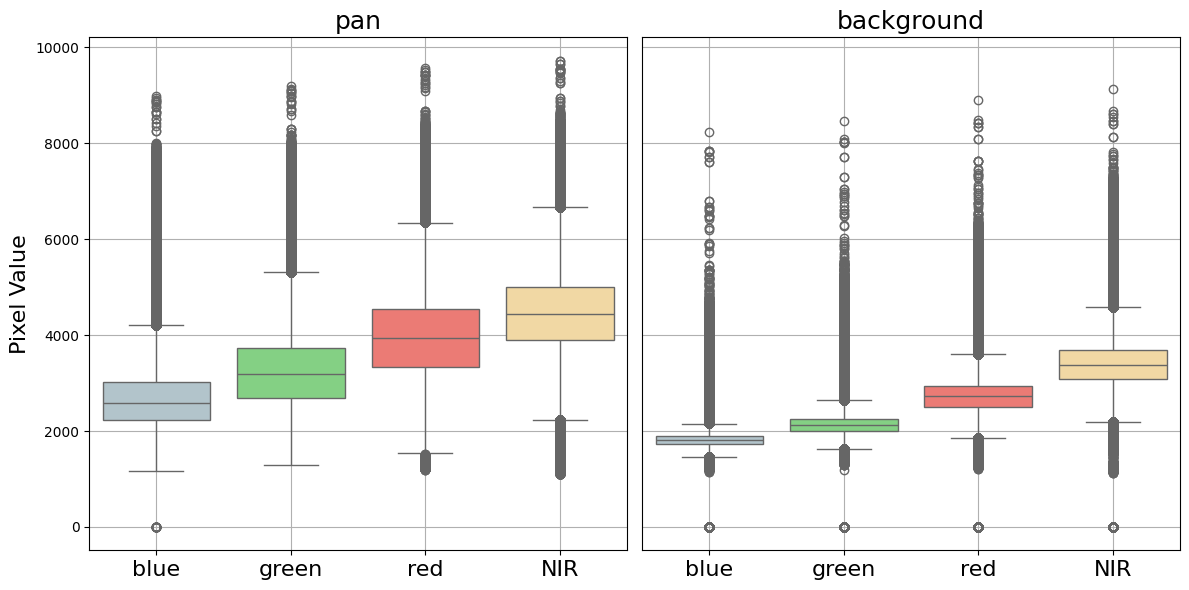

In [ ]:
#@title SENTINEL BIG IMAGE plot distribution of pan values per channel in training data

import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
from rasterio.windows import from_bounds
from glob import glob

# --- Paths ---
big_image_path = "/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/sentinel/kalahari_sentinel_merged_clip.tif"
label_dir = "/content/drive/My Drive/PAPER3_data/kalahari/pp_data/train_pp/labels/pans"

# --- Collect pixel values ---
foreground_data = [[] for _ in range(4)]
background_data = [[] for _ in range(4)]

# Read big image once
big_img = rasterio.open(big_image_path)

# Process each label tile
label_files = sorted(glob(os.path.join(label_dir, "*.tif")))

for label_path in label_files:
    with rasterio.open(label_path) as label_ds:
        label = label_ds.read(1)
        bounds = label_ds.bounds

        # Compute corresponding window in big image
        window = from_bounds(*bounds, transform=big_img.transform)
        try:
            image_crop = big_img.read(window=window)  # shape: (4, h, w)
        except:
            print(f"Skipping label {label_path} — outside bounds or read error.")
            continue

        if image_crop.shape[1:] != label.shape:
            print(f"Size mismatch in {label_path}, skipping...")
            continue

        # Create masks
        fg_mask = label > 0
        bg_mask = label == 0

        for ch in range(4):
            band = image_crop[ch]
            foreground_data[ch].extend(band[fg_mask].tolist())
            background_data[ch].extend(band[bg_mask].tolist())

big_img.close()

# --- Plot: Pan vs Background ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Define custom colors for each channel
colors = ["#AEC6CF",  # pastel blue
          "#77DD77",  # pastel green
          "#FF6961",  # pastel red
          "#FEDC97"]  # requested color

# Pan (foreground)
sns.boxplot(data=foreground_data, ax=axs[0], palette=colors)
axs[0].set_title("pan", fontsize=18)
axs[0].set_xticks([0, 1, 2, 3])
axs[0].set_xticklabels(["blue", "green", "red", "NIR"], fontsize=16)
axs[0].set_ylabel("Pixel Value", fontsize=16)
axs[0].grid(True)

# Background
sns.boxplot(data=background_data, ax=axs[1], palette=colors)
axs[1].set_title("background", fontsize=18)
axs[1].set_xticks([0, 1, 2, 3])
axs[1].set_xticklabels(["blue", "green", "red", "NIR"], fontsize=16)
axs[1].grid(True)
axs[1].tick_params(axis='y', left=False, labelleft=False, labelsize=14)


#plt.suptitle("Pixel Value Distributions from Big Image Using Small Label Tiles")
plt.tight_layout()
plt.show()


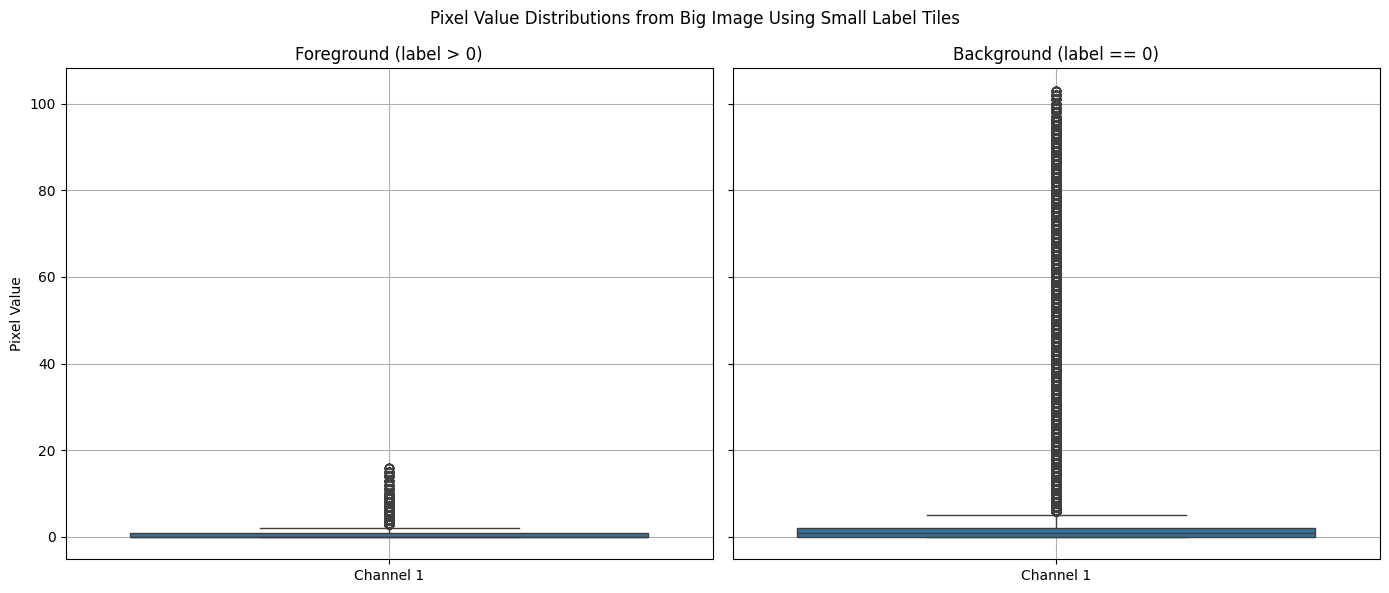

In [ ]:
#@title DEM BIG IMAGE plot distribution of pan values per channel in training data

import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install rasterio
import rasterio
import seaborn as sns
from rasterio.windows import from_bounds
from glob import glob

# --- Paths ---
big_image_path = "/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/dune_height/kalahari_dune_height_merged_clip.tif"
label_dir = "/content/drive/My Drive/PAPER3_data/kalahari/pp_data/train_pp/labels/pans"

# --- Collect pixel values ---
foreground_data = [[] for _ in range(1)]
background_data = [[] for _ in range(1)]

# Read big image once
big_img = rasterio.open(big_image_path)

# Process each label tile
label_files = sorted(glob(os.path.join(label_dir, "*.tif")))

for label_path in label_files:
    with rasterio.open(label_path) as label_ds:
        label = label_ds.read(1)
        bounds = label_ds.bounds

        # Compute corresponding window in big image
        window = from_bounds(*bounds, transform=big_img.transform)
        try:
            image_crop = big_img.read(window=window)  # shape: (1, h, w)
        except:
            print(f"Skipping label {label_path} — outside bounds or read error.")
            continue

        if image_crop.shape[1:] != label.shape:
            print(f"Size mismatch in {label_path}, skipping...")
            continue

        # Create masks
        fg_mask = label > 0
        bg_mask = label == 0

        for ch in range(1):
            band = image_crop[ch]
            foreground_data[ch].extend(band[fg_mask].tolist())
            background_data[ch].extend(band[bg_mask].tolist())

big_img.close()

# --- Plot: Foreground vs Background ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(data=foreground_data, ax=axs[0])
axs[0].set_title("Foreground (label > 0)")
axs[0].set_xticks([0])
axs[0].set_xticklabels(["Channel 1"])
axs[0].set_ylabel("Pixel Value")
axs[0].grid(True)

sns.boxplot(data=background_data, ax=axs[1])
axs[1].set_title("Background (label == 0)")
axs[1].set_xticks([0])
axs[1].set_xticklabels(["Channel 1"])
axs[1].grid(True)

plt.suptitle("Pixel Value Distributions from Big Image Using Small Label Tiles")
plt.tight_layout()
plt.show()


In [ ]:
#@title Train combined DEM + Sentinel model with validation and class balancing

import os
import numpy as np
!pip install -q rasterio
import rasterio
from rasterio.windows import from_bounds
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import joblib

# --- Paths ---
dem_path = "/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/dune_height/kalahari_dune_height_merged_clip.tif"
sentinel_path = "/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/sentinel/kalahari_sentinel_merged_clip.tif"
label_dir = "/content/drive/My Drive/PAPER3_data/kalahari/pp_data/train_pp/labels/pans"
model_path = "/content/drive/My Drive/PAPER3_data/experiments/simple_models/pan_rf_dem_sentinel.pkl"

# --- Containers ---
X = []
y = []

# Open big images once
dem_img = rasterio.open(dem_path)
sentinel_img = rasterio.open(sentinel_path)

label_files = sorted(glob(os.path.join(label_dir, "*.tif")))

for label_path in label_files:
    with rasterio.open(label_path) as label_ds:
        label = label_ds.read(1)
        bounds = label_ds.bounds

        # Get DEM window
        window_dem = from_bounds(*bounds, transform=dem_img.transform)
        window_sen = from_bounds(*bounds, transform=sentinel_img.transform)

        try:
            dem_crop = dem_img.read(window=window_dem)[0]  # shape: (H, W)
            sentinel_crop = sentinel_img.read(window=window_sen)  # shape: (4, H, W)
        except:
            print(f"Skipping {label_path} — read error.")
            continue

        if dem_crop.shape != label.shape or sentinel_crop.shape[1:] != label.shape:
            print(f"Skipping {label_path} — size mismatch.")
            continue

        # Flatten and mask
        fg_mask = np.isin(label.flatten(), [0, 1])
        if np.sum(fg_mask) == 0:
            continue

        # Features: (DEM, Sentinel 4 bands) → total 5 features
        dem_flat = dem_crop.flatten()[fg_mask].reshape(-1, 1)
        sen_flat = sentinel_crop.reshape(4, -1).T[fg_mask]  # shape: (N, 4)

        features = np.hstack((dem_flat, sen_flat))  # shape: (N, 5)
        labels = label.flatten()[fg_mask]

        X.append(features)
        y.append(labels)

# Combine all tiles
X = np.vstack(X)
y = np.hstack(y)

print(f"Total valid pixels: {len(y)}")
print(f"Before balancing: class 0 = {(y==0).sum()}, class 1 = {(y==1).sum()}")

# --- Balance dataset ---
X_0 = X[y == 0]
X_1 = X[y == 1]
y_0 = y[y == 0]
y_1 = y[y == 1]

X_0_down, y_0_down = resample(X_0, y_0, replace=False, n_samples=len(y_1), random_state=42)

X_bal = np.vstack((X_0_down, X_1))
y_bal = np.hstack((y_0_down, y_1))

print(f"After balancing: class 0 = {len(y_0_down)}, class 1 = {len(y_1)}")

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# --- Train model ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# --- Evaluate on validation set ---
print("Validation set performance:")
print(classification_report(y_test, model.predict(X_test)))

# --- Save model ---
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# --- Cleanup ---
dem_img.close()
sentinel_img.close()


Total valid pixels: 30873600
Before balancing: class 0 = 29616872, class 1 = 1256728
After balancing: class 0 = 1256728, class 1 = 1256728
Validation set performance:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    251346
         1.0       0.96      0.95      0.95    251346

    accuracy                           0.95    502692
   macro avg       0.95      0.95      0.95    502692
weighted avg       0.95      0.95      0.95    502692

Model saved to: /content/drive/My Drive/PAPER3_data/experiments/simple_models/pan_rf_dem_sentinel.pkl


In [ ]:
#@title Predict full image using trained model (DEM + Sentinel)

import numpy as np
import rasterio
import joblib
from rasterio.windows import Window
import os

!pip install -q tqdm
from tqdm import tqdm

# --- Paths ---
dem_path = "/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/dune_height/kalahari_dune_height_merged_clip.tif"
sentinel_path = "/content/drive/My Drive/DUNEMINDS_data/kalahari/img_merged/sentinel/kalahari_sentinel_merged_clip.tif"
model_path = "/content/drive/My Drive/PAPER3_data/experiments/simple_models/pan_rf_dem_sentinel.pkl"
output_path = "/content/drive/My Drive/PAPER3_data/experiments/simple_models/result_pan_dem_s2_rf.tif"

# --- Load model ---
model = joblib.load(model_path)

# --- Open images ---
dem_img = rasterio.open(dem_path)
sen_img = rasterio.open(sentinel_path)

# Check matching dimensions
assert (dem_img.height, dem_img.width) == (sen_img.height, sen_img.width), "DEM and Sentinel image shapes do not match!"

height, width = dem_img.height, dem_img.width
block_size = 512  # chunk size (adjustable for memory)

# --- Prepare output ---
meta = dem_img.meta.copy()
meta.update({
    "count": 1,
    "dtype": 'uint8',
    "compress": "lzw"
})

# --- Prediction with progress bar ---
rows = range(0, height, block_size)
cols = range(0, width, block_size)
total_blocks = len(rows) * len(cols)

with rasterio.open(output_path, 'w', **meta) as dst, tqdm(total=total_blocks, desc="Predicting") as pbar:
    for row in rows:
        for col in cols:
            win_height = min(block_size, height - row)
            win_width = min(block_size, width - col)
            window = Window(col, row, win_width, win_height)

            # Read data
            dem_block = dem_img.read(1, window=window)
            sen_block = sen_img.read(window=window)  # shape: (4, H, W)

            if np.all(np.isnan(dem_block)):
                out_block = np.zeros_like(dem_block, dtype='uint8')
            else:
                flat_dem = dem_block.flatten().reshape(-1, 1)
                flat_sen = sen_block.reshape(4, -1).T
                features = np.hstack((flat_dem, flat_sen))

                preds = model.predict(features)
                out_block = preds.reshape(dem_block.shape).astype('uint8')

            dst.write(out_block, 1, window=window)
            pbar.update(1)

print(f"✅ Prediction complete. Output saved to:\n{output_path}")


Predicting: 100%|██████████| 17582/17582 [3:07:56<00:00,  1.56it/s]

✅ Prediction complete. Output saved to:
/content/drive/My Drive/PAPER3_data/experiments/simple_models/result_pan_dem_s2_rf.tif


In [ ]:
#@title Raster Calculator

#!pip install gdal
import numpy as np
from osgeo import gdal

# --- Input file paths ---
layerA_path = "/content/drive/My Drive/PAPER3_data/experiments/simple_models/roads_rivers_buffer.tif"        # This contains 10s and 0s
layerB_path = "/content/drive/My Drive/PAPER3_data/experiments/simple_models/result_pan_dem_s2_rf.tif"     # The values you want to preserve
output_path = "/content/drive/My Drive/PAPER3_data/experiments/simple_models/result_pan_dem_s2_rf_rmrrpy.tif"       # Output file

# --- Open input datasets ---
dsA = gdal.Open(layerA_path)
dsB = gdal.Open(layerB_path)

# Check if the datasets were opened successfully
if dsA is None:
    raise Exception(f"Failed to open layer A: {layerA_path}")
if dsB is None:
    raise Exception(f"Failed to open layer B: {layerB_path}")

bandA = dsA.GetRasterBand(1)
bandB = dsB.GetRasterBand(1)

arrayA = bandA.ReadAsArray()
arrayB = bandB.ReadAsArray()

# Handle NoData
nodataA = bandA.GetNoDataValue()
nodataB = bandB.GetNoDataValue()

# Create output array:
# If A == 10 → 0
# Else → value from B
output = np.where(arrayA == 10, 0, arrayB)

# Where A is NoData, use B
if nodataA is not None:
    output = np.where(arrayA == nodataA, arrayB, output)

# --- Save output ---
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(
    output_path,
    dsA.RasterXSize,
    dsA.RasterYSize,
    1,
    gdal.GDT_Float32
)

out_ds.SetGeoTransform(dsA.GetGeoTransform())
out_ds.SetProjection(dsA.GetProjection())

out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(output)

# Set NoData if layerB had it
if nodataB is not None:
    out_band.SetNoDataValue(nodataB)

out_band.FlushCache()
out_ds = None

print("Done! Output saved to:", output_path)


Done! Output saved to: /content/drive/My Drive/PAPER3_data/experiments/simple_models/result_pan_dem_s2_rf_rmrrpy.tif


# Analysis

In [7]:
#@title Pre-processing

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import os
from scipy.stats import pearsonr, spearmanr, normaltest
from scipy.stats import chi2_contingency, kruskal

# Load dataset
df = pd.read_csv("/content/drive/My Drive/PAPER3_data/analysis/points_final_5km_clip_values7.csv")
base_dir = "/content/drive/My Drive/PAPER3_data/analysis"
scatterplot_dir = os.path.join(base_dir, "scatterplotsNEW2")
boxplot_dir = os.path.join(base_dir, "boxplotsNEW2")
crosstab_dir = os.path.join(base_dir, "crosstabsNEW2")
histogram_dir = os.path.join(base_dir, "histogramsNEW2")

# Rename columns
df.rename(columns={
    "kalahari_dune_height_agg_max2880": "dune_height_max2880",
    "kalahari_dune_height_agg_quart-3-2880": "dune_height_quart3",
    "wavelength_resample2880": "wavelength",
    "kalahari_topo_100": "topo",
    "topo_100_roughness_reproj2880m": "roughness",
    "orientation_variance_new": "orientation_variance",
    "kalahari_copdem_merged_clip_tiff_resample60m_aspect_2880modegg": "orientation_mode",
    "kalahari_sand_volume_agg2880": "sand_volume",
    "result_pan_dem_s2_rf_rmrrproj_50sieve_aggavg2880": "pan_density",
    "waterways_EW_5km": "river_proximity_EW_5k",
    "waterways_NS_5km": "river_proximity_NS_5k",
    "result_pan_dem_s2_rf_rmrrproj_500sieve_5km": "pan_proximity_5k",
    "res_pred_merged_clip_tiff_UMAP4_final": "umap4",
    "bullard_pattern_map_final": "bullard_map",
    "height_max100": "dune_height"
}, inplace=True)

# Change orientation mode from 8 to 5 classes
df["orientation_mode"] = df["orientation_mode"].replace({6: 4, 7: 3, 8: 2})


df_full = df.copy()


#df = df[df["umap4"] != 0]
df = df[df["dune_height"] < 45]

# drop columns that are not needed
df = df.drop('rand', axis=1)
df = df.drop("wavelength_meas", axis=1)
df = df.drop("dune_height_max2880", axis=1)
df = df.drop("dune_height_quart3", axis=1)
df = df.drop("fid", axis=1)
df = df.drop("wavelength_predict", axis=1)
df = df.drop("wavelength_predict2", axis=1)
#df = df.drop("wl_pred_xgb", axis=1)
df = df.drop("results_merged_wavelength", axis=1)
df = df.drop("aspect_circular_variance2880", axis=1)
df = df.drop("roughness", axis=1)


# Define categorical variables
categorical_vars = ["umap4", "bullard_map", "orientation_mode", "river_proximity_EW_5k", "river_proximity_NS_5k", "pan_proximity_5k"]

# Define dune height variables
dune_height_cols = ["dune_height_max2880", "dune_height_max100", "dune_height_quart3"]

# Create output directories
os.makedirs(scatterplot_dir, exist_ok=True)
os.makedirs(boxplot_dir, exist_ok=True)
os.makedirs(crosstab_dir, exist_ok=True)
os.makedirs(histogram_dir, exist_ok=True)



In [6]:
df

,topo,orientation_mode,sand_volume,pan_density,river_proximity_EW_5k,river_proximity_NS_5k,pan_proximity_5k,umap4,bullard_map,dune_height,wavelength,orientation_variance,main_orientation_label,umap4_label
0,NaN,3,6083,0.00000,0,0,0,NaN,NaN,0,537.570068,2.411524,NW-SE,NaN
1,NaN,4,34461,0.00368,0,0,0,0.0,0.0,25,537.570068,3.127282,NNW-SSE,0.0
2,1414.0,5,54121,0.00000,0,1,1,0.0,0.0,12,537.624783,1.903913,N-S,0.0
3,1431.0,5,48126,0.02075,0,1,1,0.0,0.0,3,537.268555,3.393370,N-S,0.0
4,1462.0,3,48263,0.00727,0,0,1,0.0,0.0,2,537.570068,5.016165,NW-SE,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,837.0,1,43719,0.31769,0,0,1,0.0,0.0,3,526.588955,5.870768,W-E,0.0
7792,859.0,4,78227,0.00911,0,0,1,0.0,0.0,5,537.671468,3.336548,NNW-SSE,0.0
7793,875.0,2,147407,0.00093,0,0,0,2.0,0.0,17,525.618320,5.360046,WNW-ESE,2.1
7794,884.0,3,57027,0.00000,0,0,0,0.0,0.0,4,537.570068,4.591559,NW-SE,0.0


In [ ]:
#@title descriptive stats

desc_stats = df.describe(include='all').transpose()
desc_stats.to_csv(os.path.join(base_dir, "descriptive_statistics.csv"))
print("Descriptive statistics saved to 'descriptive_statistics.csv'")

Descriptive statistics saved to 'descriptive_statistics.csv'


In [ ]:
#@title histograms

for col in df.columns:
    plt.figure(figsize=(6, 4))
    if col in dune_height_cols:
        plot_df = df[(df[col] >= 2) & (df[col] <= 35)]
    else:
        plot_df = df

    if col in categorical_vars:
        sns.countplot(x=col, data=plot_df)
        plt.title(f"Count plot of {col}")
    else:
        sns.histplot(plot_df[col].dropna(), kde=True, bins=30)
        plt.title(f"Histogram of {col}")
    plt.tight_layout()
    plt.savefig(f"{histogram_dir}/{col}_distribution.png")
    plt.close()



In [3]:
#@title custom cmap

from matplotlib.colors import LinearSegmentedColormap

# Define your custom colors
custom_colors = [
    #'#6e4731',  # Dark brown
    '#996d52',  # Brown
    '#c19774',  # Tan
    '#e3c796',  # Light beige
    '#deddaf',  # Pale yellow
    '#bbc2ac',  # Sage green
    '#8fa8af',  # Cool grey-blue
    '#4492bb'   # Blue
]

# Create smooth colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_smooth", custom_colors, N=256)


# Reversed for inverse
custom_colors_reversed = custom_colors[::-1]

# Create reversed (inverted) colormap
custom_cmap_inverse = LinearSegmentedColormap.from_list(
    "earth_to_cool_inverse", custom_colors_reversed, N=256
)


# Define your own yellow-to-brown color progression
ylbr_colors = ["#ffffcc", "#e3c796", "#c19774", "#996d52", "#6e4731"]

# Create a custom colormap from the list
ylbr_cmap = LinearSegmentedColormap.from_list("CustomYlBr", ylbr_colors)

topo
topo
spearman
sand_volume
spearman
pan_density
spearman
dune_height
spearman
wavelength
spearman
orientation_variance
spearman
sand_volume
topo
spearman
sand_volume
spearman
pan_density
spearman
dune_height
spearman
wavelength
spearman
orientation_variance
spearman
pan_density
topo
spearman
sand_volume
spearman
pan_density
spearman
dune_height
spearman
wavelength
spearman
orientation_variance
spearman
dune_height
topo
spearman
sand_volume
spearman
pan_density
spearman
dune_height
spearman
wavelength
spearman
orientation_variance
spearman
wavelength
topo
spearman
sand_volume
spearman
pan_density
spearman
dune_height
spearman
wavelength
spearman
orientation_variance
spearman
orientation_variance
topo
spearman
sand_volume
spearman
pan_density
spearman
dune_height
spearman
wavelength
spearman
orientation_variance
spearman


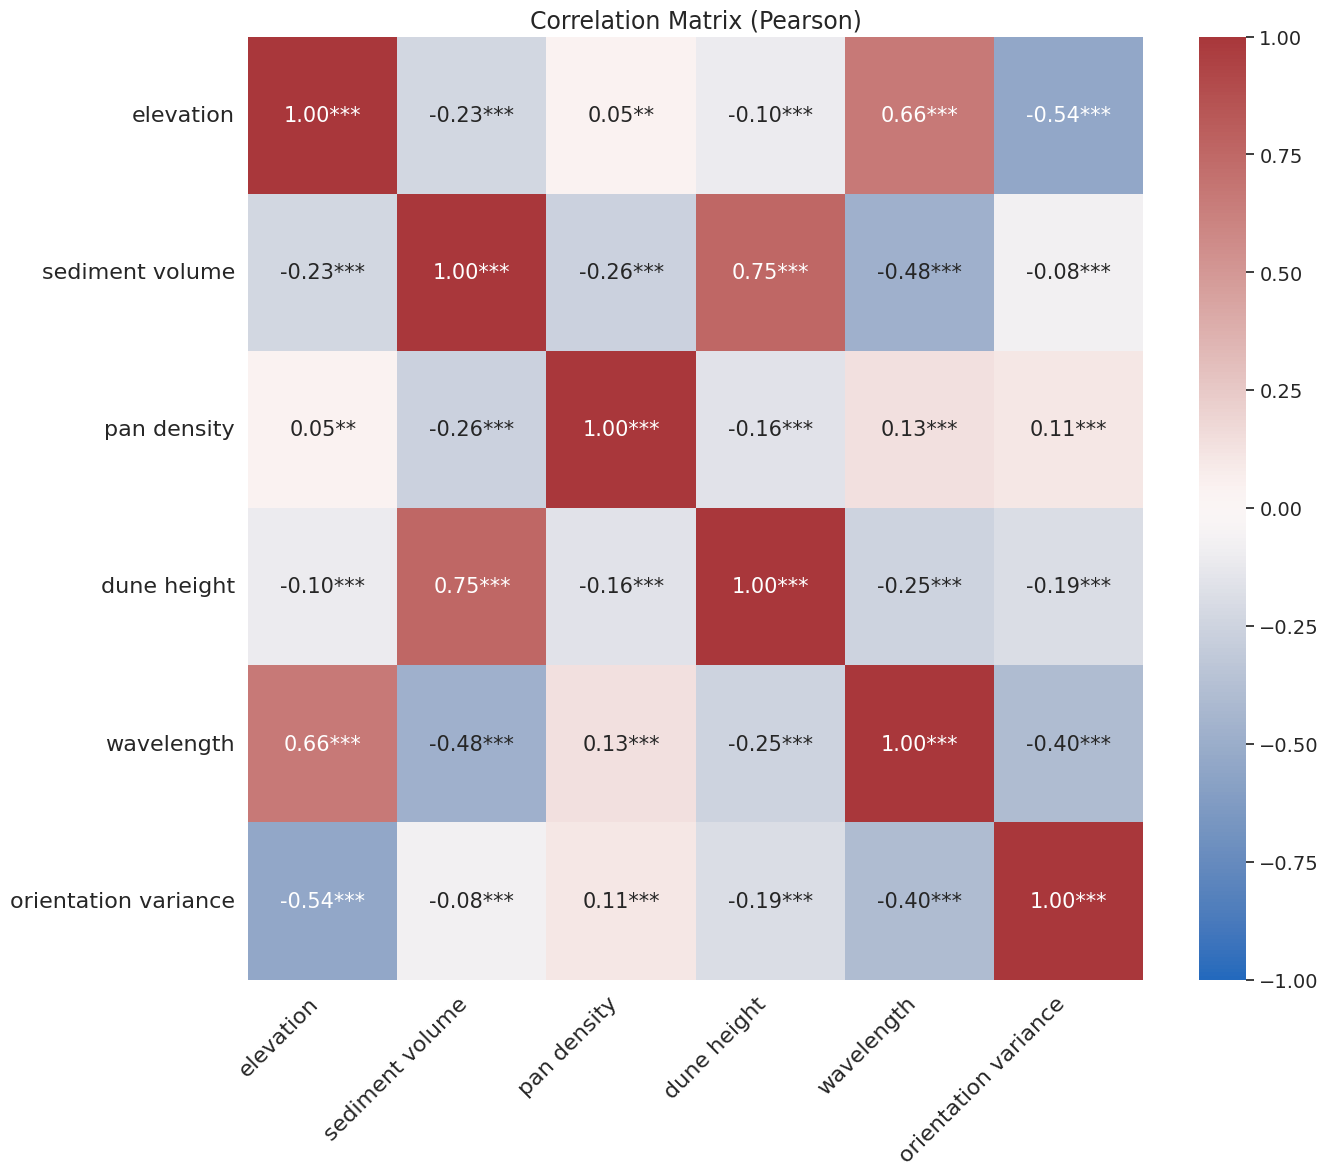

In [ ]:
#@title Correlation matrix

import numpy as np

# Define numeric columns excluding categorical
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in categorical_vars]


# Prepare two matrices
cor_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols, dtype=float)
cor_sig_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols, dtype=object)

for var1 in numeric_cols:
    print(var1)
    for var2 in numeric_cols:
        print(var2)
        temp_df = df[[var1, var2]].copy()

        if var1 in dune_height_cols:
            temp_df = temp_df[(temp_df[var1] >= 2) & (temp_df[var1] <= 35)]
        if var2 in dune_height_cols:
            temp_df = temp_df[(temp_df[var2] >= 2) & (temp_df[var2] <= 35)]

        temp_df = temp_df.dropna()

        if len(temp_df) > 7:
            data1 = temp_df.iloc[:, 0]
            data2 = temp_df.iloc[:, 1]

            p_norm1 = normaltest(data1)[1]
            p_norm2 = normaltest(data2)[1]

            # Choose method based on normality
            if p_norm1 > 0.05 and p_norm2 > 0.05:
                corr_val, p_val = pearsonr(data1, data2)
                print("pearson")
            else:
                corr_val, p_val = spearmanr(data1, data2)
                print("spearman")

            # Significance stars
            if p_val <= 0.001:
                stars = '***'
            elif p_val <= 0.01:
                stars = '**'
            elif p_val <= 0.05:
                stars = '*'
            else:
                stars = ''

            # Save values
            cor_matrix.loc[var1, var2] = corr_val
            cor_sig_matrix.loc[var1, var2] = f"{corr_val:.2f}{stars}"
        else:
            cor_matrix.loc[var1, var2] = np.nan
            cor_sig_matrix.loc[var1, var2] = ""

# Plot
# Plot with color-blind friendly palette and larger text

# custom labels
custom_labels = {
    'topo': 'elevation',
    'sand_volume': 'sediment volume',
    'dune_height': 'dune height',
    'pan_density': 'pan density',
    'orientation_variance': 'orientation variance'
}

tick_labels = [custom_labels.get(var, var) for var in numeric_cols]

plt.figure(figsize=(14, 12))
sns.set(font_scale=1.2)  # Increase overall font size

sns.heatmap(
    cor_matrix.astype(float),
    annot=cor_sig_matrix,
    fmt='',
    cmap='vlag',  # color-blind friendly diverging palette #vlag
    vmin=-1,
    vmax=1,
    cbar=True,
    annot_kws={"size": 15}  # Increase annotation text size
)

cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right', fontsize=16)
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, fontsize=16)

plt.title("Correlation Matrix (Pearson)", fontsize=17)
plt.tight_layout()
plt.savefig(f"{base_dir}/correlation_matrix_significance.png", dpi=300)
plt.show()




ValueError: List of boxplot statistics and `positions` values must have same the length

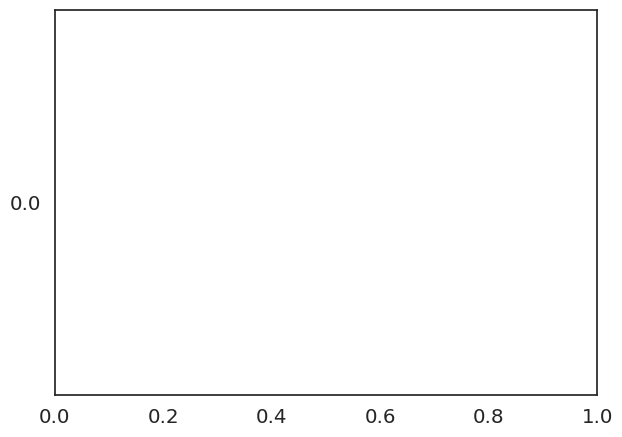

In [8]:
#@title pairwise plots (boxplots, scatterplots, crosstabs) NEW


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency, kruskal

# Custom label mapping
custom_labels = {
    'topo': 'elevation [m]',
    'sand_volume': 'sediment volume [cell x m]',
    'dune_height': 'max dune height [m]',
    'pan_density': 'pan density',
    'orientation_variance': 'orientation variance',
    'wavelength': 'wavelength [m]',
    'river_proximity_EW_5k': 'valley adjacency W-E',
    'river_proximity_NS_5k': 'valley adjacency N-S',
    'pan_proximity_5k': 'pan adjacency',
    'orientation_mode': 'main orientation',
    'bullard_map': 'bullard map',
    'umap4': 'umap4'
}

# Orientation label mapping
orientation_labels = {
    1: 'W-E',
    2: 'WNW-ESE',
    3: 'NW-SE',
    4: 'NNW-SSE',
    5: 'N-S',
    6: 'NNE-SSW',
    7: 'NE-SW',
    8: 'ENE-WSW'
}

# determine order for boxplots incl main orientaion
desired_order = [
    'W-E',
    'WNW-ESE',
    'NW-SE',
    'NNW-SSE',
    'N-S'
]

# UMAP4 label mapping and order
umap4_labels = {
    0: '0.0',
    1: '3.0',
    2: '2.1',
    3: '4.0',
    4: '2.0'
}
#umap4_order = ['0', '4', '2', '1', '3']
umap4_order = ['0.0', '2.0', '2.1', '3.0', '4.0']


# Add human-readable orientation label column
df["main_orientation_label"] = df["orientation_mode"].map(orientation_labels)
df["umap4_label"] = df["umap4"].map(umap4_labels)


# Custom color palettes
column_cmap = sns.light_palette("#4492bb", as_cmap=True)
earthy_colors = ["#bbc2ac", "#deddaf", "#e3c796", "#c19774", "#996d52", "#6e4731"]
earthy_cmap = sns.color_palette(earthy_colors, as_cmap=True)

# Significance stars
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Plotting style
sns.set_style("white")
sns.set_context("notebook", font_scale=1.3)

for var1, var2 in combinations(df.columns, 2):

    # Apply dune height filter
    if var1 in dune_height_cols or var2 in dune_height_cols:
        plot_df = df.copy()
        for dune_col in dune_height_cols:
            if dune_col in [var1, var2]:
                plot_df = plot_df[(plot_df[dune_col] >= 2) & (plot_df[dune_col] <= 35)]
    else:
        plot_df = df

    # ------------------ CROSSTABS ------------------
    if var1 in categorical_vars and var2 in categorical_vars:
        ctab = pd.crosstab(plot_df[var1], plot_df[var2])
        chi2, p, dof, ex = chi2_contingency(ctab)
        stars = p_to_stars(p)

        def relabel_orientation(axis, tick_values):
            labels = [orientation_labels.get(int(val), str(val)) for val in tick_values]
            axis.set_ticklabels(labels, fontsize=16)


        # Raw count heatmap
        plt.figure(figsize=(6, 5))
        ax = sns.heatmap(ctab, annot=True, fmt="d", cmap="YlGn")
        plt.title(f"\nChi-square p = {p:.3f} {stars}", fontsize=17)
        plt.xlabel(custom_labels.get(var2, var2), fontsize=16)
        plt.ylabel(custom_labels.get(var1, var1), fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16, rotation=0)
        if var1 == "orientation_mode":
            tickvals = [tick.get_text() for tick in ax.get_yticklabels()]
            relabel_orientation(ax.yaxis, tickvals)
        if var2 == "orientation_mode":
            tickvals = [tick.get_text() for tick in ax.get_xticklabels()]
            relabel_orientation(ax.xaxis, tickvals)

        plt.tight_layout()
        plt.savefig(f"{crosstab_dir}/{var1}_vs_{var2}_crosstab_counts.png")
        plt.close()

        # Row %
        row_pct = ctab.div(ctab.sum(axis=1), axis=0) * 100
        plt.figure(figsize=(6, 5))
        ax = sns.heatmap(row_pct, annot=True, fmt=".1f", cmap="Blues")
        plt.title("Crosstab row percentages", fontsize=17)
        plt.xlabel(custom_labels.get(var2, var2), fontsize=16)
        plt.ylabel(custom_labels.get(var1, var1), fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16, rotation=0)
        if var1 == "orientation_mode":
            tickvals = [tick.get_text() for tick in ax.get_yticklabels()]
            relabel_orientation(ax.yaxis, tickvals)
        if var2 == "orientation_mode":
            tickvals = [tick.get_text() for tick in ax.get_xticklabels()]
            relabel_orientation(ax.xaxis, tickvals)
        plt.tight_layout()
        plt.savefig(f"{crosstab_dir}/{var1}_vs_{var2}_crosstab_rowpct.png")
        plt.close()

        # Column %
        col_pct = ctab.div(ctab.sum(axis=0), axis=1) * 100
        plt.figure(figsize=(6, 5))
        ax = sns.heatmap(col_pct, annot=True, fmt=".1f", cmap=ylbr_cmap)
        plt.title("Crosstab column percentages", fontsize=17)
        plt.xlabel(custom_labels.get(var2, var2), fontsize=16)
        plt.ylabel(custom_labels.get(var1, var1), fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16, rotation=0)
        if var1 == "orientation_mode":
            tickvals = [tick.get_text() for tick in ax.get_yticklabels()]
            relabel_orientation(ax.yaxis, tickvals)
        if var2 == "orientation_mode":
            tickvals = [tick.get_text() for tick in ax.get_xticklabels()]
            relabel_orientation(ax.xaxis, tickvals)
        plt.tight_layout()
        plt.savefig(f"{crosstab_dir}/{var1}_vs_{var2}_crosstab_colpct.png")
        plt.close()

    # ------------------ BOXPLOTS ------------------
    elif (var1 in categorical_vars and var2 not in categorical_vars) or (var2 in categorical_vars and var1 not in categorical_vars):
        cat_var = var1 if var1 in categorical_vars else var2
        num_var = var2 if cat_var == var1 else var1

        groups = [group[num_var].dropna() for name, group in plot_df.groupby(cat_var)]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            stars = p_to_stars(p)
            title = f"\nKruskal-Wallis p = {p:.3f} {stars}"
        else:
            title = f"{custom_labels.get(num_var, num_var)} by {custom_labels.get(cat_var, cat_var)}\nInsufficient groups"

        cat_plot_var = "main_orientation_label" if cat_var == "orientation_mode" else cat_var
        order = desired_order if cat_var == "orientation_mode" else (umap4_order if cat_var == "umap4" else None)

        plt.figure(figsize=(7, 5))
        sns.boxplot(x=cat_plot_var, y=num_var, data=plot_df, color="#4492bb", order=order)

        plt.title(title, fontsize=17)
        plt.xlabel(custom_labels.get(cat_var, cat_var), fontsize=15)
        plt.ylabel(custom_labels.get(num_var, num_var), fontsize=15)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(f"{boxplot_dir}/{num_var}_by_{cat_var}_boxplot.png")
        plt.close()

    # ------------------ SCATTERPLOTS ------------------
    elif var1 not in categorical_vars and var2 not in categorical_vars:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=var1, y=var2, data=plot_df)
        plt.title(f"{custom_labels.get(var1, var1)} vs {custom_labels.get(var2, var2)}", fontsize=17)
        plt.xlabel(custom_labels.get(var1, var1), fontsize=16)
        plt.ylabel(custom_labels.get(var2, var2), fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{scatterplot_dir}/{var1}_vs_{var2}.png")
        plt.close()

print("✅ All plots and significance tests (with stars) saved.")

In [ ]:
#@title plot orientation mode x elevation boxplot

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal

# Custom label mapping
custom_labels = {
    'topo': 'elevation [m]',
    'sand_volume': 'sediment volume [cell x m]',
    'dune_height': 'max dune height [m]',
    'pan_density': 'pan density',
    'orientation_variance': 'orientation variance',
    'wavelength': 'wavelength [m]',
    'river_proximity_EW_5k': 'river adjacency W-E',
    'river_proximity_NS_5k': 'river adjacency N-S',
    'pan_proximity_5k': 'pan adjacency',
    'orientation_mode': 'main orientation',
    'bullard_map': 'bullard map',
    'umap4': 'umap4'
}

# Orientation label mapping
orientation_labels = {
    1: 'E-W',
    2: 'ESE-WNW',
    3: 'SE-NW',
    4: 'NNW-SSE',
    5: 'N-S'
}

variable = "orientation_variance"

# Map human-readable orientation labels
df["main_orientation_label"] = df["orientation_mode"].map(orientation_labels)

# Set categorical order
orientation_order = [orientation_labels[i] for i in sorted(orientation_labels.keys())]
df["main_orientation_label"] = pd.Categorical(df["main_orientation_label"], categories=orientation_order, ordered=True)

# Kruskal-Wallis test
groups = [group[variable].dropna() for name, group in df.groupby("main_orientation_label")]
stat, p = kruskal(*groups)

# Significance stars
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

stars = p_to_stars(p)

# Plot
plt.figure(figsize=(6, 5))
sns.boxplot(x="main_orientation_label", y=variable, data=df, color="#4492bb")
plt.title(f"\nKruskal-Wallis p = {p:.3f} {stars}", fontsize=17)
plt.xlabel(custom_labels["orientation_mode"], fontsize=15)
plt.ylabel(custom_labels[variable], fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig(f"{boxplot_dir}/{variable}_by_orientation_mode_boxplot.png")
plt.close()

/tmp/ipython-input-8-4001011065.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[variable].dropna() for name, group in df.groupby("main_orientation_label")]


In [ ]:
df

,topo,orientation_mode,sand_volume,pan_density,river_proximity_EW_5k,river_proximity_NS_5k,pan_proximity_5k,umap4,bullard_map,dune_height,wavelength,orientation_variance,main_orientation_label
0,NaN,3,6083,0.00000,0,0,0,NaN,NaN,0,537.570068,2.411524,SE-NW
8,1514.0,4,29043,0.00244,0,0,1,2.0,0.0,2,514.919291,3.500078,NNW-SSE
11,1484.0,5,29264,0.00000,0,0,0,2.0,0.0,2,519.477227,4.262147,N-S
15,1413.0,5,102936,0.00000,1,1,0,2.0,0.0,3,527.986115,5.273119,N-S
17,1311.0,3,45438,0.00000,1,1,0,2.0,0.0,3,519.657088,6.348973,SE-NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7760,841.0,3,75277,0.00136,1,1,0,2.0,0.0,6,534.517137,3.736626,SE-NW
7761,899.0,4,187108,0.00000,1,1,0,2.0,1.0,7,511.287143,4.338844,NNW-SSE
7762,907.0,5,87700,0.00157,0,0,0,4.0,1.0,6,366.928760,3.174766,N-S
7790,829.0,3,176470,0.22978,0,0,1,2.0,0.0,10,521.622314,2.203640,SE-NW


Number of samples used for plot: 122


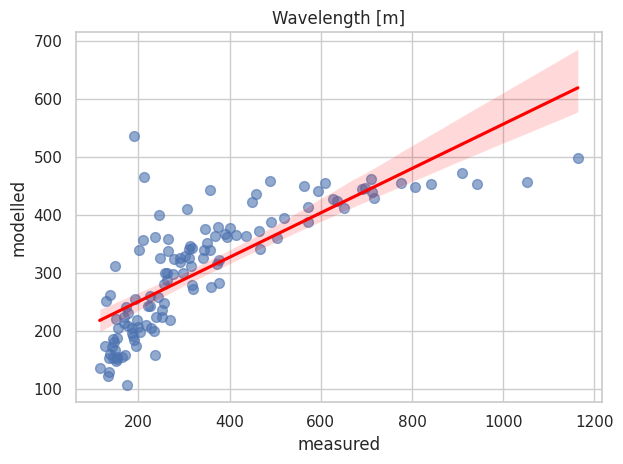

In [ ]:
#@title Wavelength check measured vs modelled


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Copy and keep only necessary columns, drop rows with NaNs in those
df_subset = df_full[["wavelength_meas", "wavelength"]].copy().dropna()

# Print how many samples are used
print(f"Number of samples used for plot: {len(df_subset)}")


# Scatterplot with regression line
sns.set(style="whitegrid")
ax = sns.regplot(
    data=df_subset,
    x="wavelength_meas",
    y="wavelength",
    scatter_kws={"s": 50, "alpha": 0.6},
    line_kws={"color": "red"}
)

# Compute R²
r2 = r2_score(df_subset["wavelength_meas"], df_subset["wavelength"])

'''
# Annotate R² on the plot
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top'
)
'''

# Axis labels
plt.xlabel("measured")
plt.ylabel("modelled")
plt.title("Wavelength [m]")
plt.tight_layout()
plt.show()


Number of samples used for plot: 122
0.49583777484284863


/tmp/ipython-input-10-337032826.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


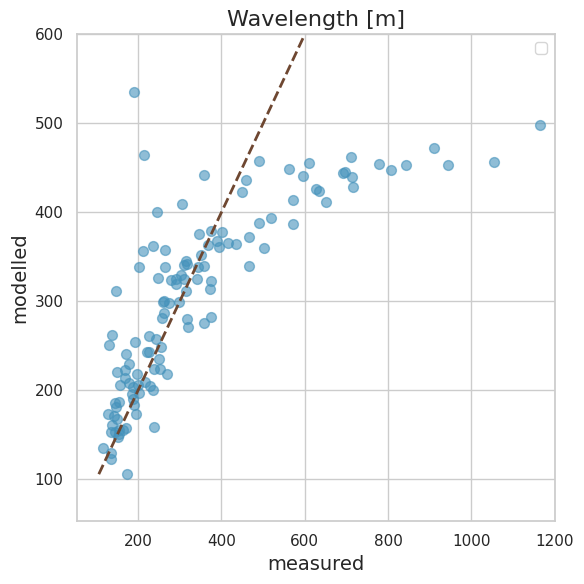

In [ ]:
#@title Wavelength check measured vs modelled: IDENTITY LINE

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Custom colors
custom_colors = [
    "#6e4731",  # brown (for the identity line)
    "#a77a5d",
    "#d9b68a",
    "#d3d4ad",
    "#a0b1ae",
    "#4492bb"   # darkest blue (for the points)
]

# Copy and keep only necessary columns, drop rows with NaNs in those
df_subset = df_full[["wavelength_meas", "wavelength"]].copy().dropna()

# Print how many samples are used
print(f"Number of samples used for plot: {len(df_subset)}")

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Scatterplot without regression line
plt.scatter(
    df_subset["wavelength_meas"],
    df_subset["wavelength"],
    s=50,
    alpha=0.6,
    color=custom_colors[-1]  # darkest blue
)

# Identity line (perfect agreement)
min_val = min(df_subset["wavelength_meas"].min(), df_subset["wavelength"].min())
max_val = max(df_subset["wavelength_meas"].max(), df_subset["wavelength"].max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color=custom_colors[0],  # brown
    linestyle="--",
    linewidth=2
    #label="Perfect agreement"
)

# Compute R²
r2 = r2_score(df_subset["wavelength_meas"], df_subset["wavelength"])
print(r2)

# Optional: Annotate R² on the plot
# plt.text(
#     0.05, 0.95,
#     f"$R^2$ = {r2:.3f}",
#     transform=plt.gca().transAxes,
#     fontsize=12,
#     verticalalignment='top'
# )

plt.ylim(top=600)
plt.xlim(right=1200)

# Labels and title
plt.xlabel("measured", fontsize=14)
plt.ylabel("modelled", fontsize=14)
plt.title("Wavelength [m]", fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
#@title Wavelength prediction xgboost

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare training data (only where both measured and modelled exist)
df_train = df_full[["wavelength", "wavelength_meas"]].dropna()

X = df_train[["wavelength"]]  # modelled wavelength (feature)
y = df_train["wavelength_meas"]  # measured wavelength (target)

# 2. Train/test split for validation (optional but recommended)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# 4. Evaluate (optional)
y_pred = model.predict(X_val)

# Compute RMSE manually
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.2f}")
# compute R2
print(f"R²: {r2_score(y_val, y_pred):.3f}")

# 5. Apply model to all rows where modelled wavelength is available
df_predict = df_full[df_full["wavelength"].notna()].copy()
df_predict["wavelength_meas_pred"] = model.predict(df_predict[["wavelength"]])

# 6. Merge predictions back into full dataset
df_full_with_preds = df_full.copy()
df_full_with_preds.loc[df_predict.index, "wavelength_meas_pred"] = df_predict["wavelength_meas_pred"]


RMSE: 82.45
R²: 0.816


In [ ]:
#@title predict wavelength + apply to raster

import rasterio
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

raster_path = "/content/drive/My Drive/PAPER3_data/kalahari/other_downloads/results_merged_wavelength.tif"
output_path = "/content/drive/My Drive/PAPER3_data/kalahari/topography_2/wavelength_xgb_pred.tif"

# 1. Load the raster
with rasterio.open(raster_path) as src:
    wavelength_data = src.read(1)  # read first band
    profile = src.profile

# 2. Prepare data for training (if applicable)
# Let's assume you extracted df_full from raster + measurements before this step

df_train = df_full[["wavelength", "wavelength_meas"]].dropna()
X = df_train[["wavelength"]]
y = df_train["wavelength_meas"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# 3. Evaluate
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2_score(y_val, y_pred):.3f}")

# 4. Predict for entire raster
wavelength_flat = wavelength_data.flatten()
mask = ~np.isnan(wavelength_flat)

# Create empty array for predictions
wavelength_meas_pred_flat = np.full_like(wavelength_flat, np.nan, dtype=np.float32)

# Predict only on valid (non-NaN) pixels
wavelength_meas_pred_flat[mask] = model.predict(wavelength_flat[mask].reshape(-1, 1))

# Reshape back to original raster shape
wavelength_meas_pred = wavelength_meas_pred_flat.reshape(wavelength_data.shape)

# 5. Save predicted raster

profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(wavelength_meas_pred, 1)

print(f"Saved predicted raster to: {output_path}")


RMSE: 82.45
R²: 0.816
Saved predicted raster to: /content/drive/My Drive/PAPER3_data/kalahari/topography_2/wavelength_xgb_pred.tif


In [ ]:
df_full_with_preds

,fid,dune_height_max2880,dune_height_quart3,wavelength,topo,roughness,orientation_variance,orientation_mode,sand_volume,pan_density,...,river_proximity_NS_5k,pan_proximity_5k,umap4,bullard_map,dune_height_max100,rand,wavelength_meas,wavelength_predict,wavelength_predict2,wavelength_meas_pred
0,1,2,0.0,537.55396,NaN,0.19738,0.13961,7,6083,0.00000,...,0,0,NaN,NaN,0,8,NaN,788.098755,816.387878,190.010193
1,2,14,1.0,537.55396,NaN,0.11922,0.66209,6,34461,0.00368,...,0,0,0.0,0.0,25,15,NaN,788.098755,816.387878,190.010193
2,3,19,1.0,537.55396,1414.0,0.43901,0.14832,5,54121,0.00000,...,1,1,0.0,0.0,12,26,NaN,788.098755,816.387878,190.010193
3,4,6,1.0,535.56488,1431.0,0.10595,0.35262,5,48126,0.02075,...,1,1,0.0,0.0,3,5,NaN,782.173157,810.075378,1163.773438
4,5,3,1.0,537.55396,1462.0,0.03845,0.67426,3,48263,0.00727,...,0,1,0.0,0.0,2,19,NaN,788.098755,816.387878,190.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,7792,8,1.0,539.86609,837.0,0.15410,0.59743,1,43719,0.31769,...,0,1,0.0,0.0,3,30,NaN,814.058228,830.404541,190.010193
7792,7793,8,1.0,540.89655,859.0,0.16941,0.60834,4,78227,0.00911,...,0,1,0.0,0.0,5,5,NaN,788.098755,824.419006,190.010193
7793,7794,18,2.0,501.82007,875.0,0.17104,0.46268,2,147407,0.00093,...,0,0,2.0,0.0,17,12,NaN,777.808167,824.095703,942.953003
7794,7795,10,1.0,537.55396,884.0,0.17239,0.48773,3,57027,0.00000,...,0,0,0.0,0.0,4,32,NaN,621.518738,816.387878,190.010193


Number of samples used for plot: 58


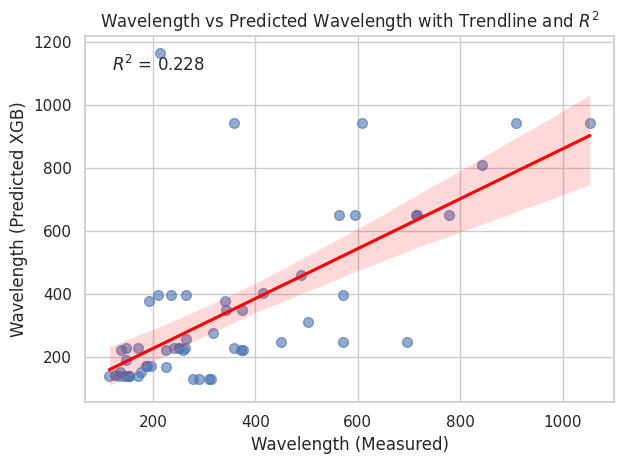

In [ ]:
#@title Wavelength check measured vs PREDICTED by XGBOOST

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Filter to only include rows where rand == 1
df_subset = df_full[df_full["rand"] == 1][["wavelength_meas", "wl_pred_xgb"]].copy()
df_subset = df_subset.dropna()

# Print how many samples are used
print(f"Number of samples used for plot: {len(df_subset)}")

# Scatterplot with regression line
sns.set(style="whitegrid")
ax = sns.regplot(
    data=df_subset,
    x="wavelength_meas",
    y="wl_pred_xgb",
    scatter_kws={"s": 50, "alpha": 0.6},
    line_kws={"color": "red"}
)

# Compute R²
r2 = r2_score(df_subset["wavelength_meas"], df_subset["wl_pred_xgb"])

# Annotate R² on the plot
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top'
)

# Axis labels
plt.xlabel("Wavelength (Measured)")
plt.ylabel("Wavelength (Predicted XGB)")
plt.title("Wavelength vs Predicted Wavelength with Trendline and $R^2$")
plt.tight_layout()
plt.show()


In [ ]:
df_full

,fid,dune_height_max2880,dune_height_quart3,results_merged_wavelength,topo,roughness,aspect_circular_variance2880,orientation_mode,sand_volume,pan_density,...,pan_proximity_5k,umap4,bullard_map,dune_height,rand,wavelength_meas,wavelength_predict,wavelength_predict2,wavelength,orientation_variance
0,1,2,0.0,537.55396,NaN,0.19738,0.13961,3,6083,0.00000,...,0,NaN,NaN,0,8,NaN,788.098755,816.387878,537.570068,2.411524
1,2,14,1.0,537.55396,NaN,0.11922,0.66209,4,34461,0.00368,...,0,0.0,0.0,25,15,NaN,788.098755,816.387878,537.570068,3.127282
2,3,19,1.0,537.55396,1414.0,0.43901,0.14832,5,54121,0.00000,...,1,0.0,0.0,12,26,NaN,788.098755,816.387878,537.624783,1.903913
3,4,6,1.0,535.56488,1431.0,0.10595,0.35262,5,48126,0.02075,...,1,0.0,0.0,3,5,NaN,782.173157,810.075378,537.268555,3.393370
4,5,3,1.0,537.55396,1462.0,0.03845,0.67426,3,48263,0.00727,...,1,0.0,0.0,2,19,NaN,788.098755,816.387878,537.570068,5.016165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,7792,8,1.0,539.86609,837.0,0.15410,0.59743,1,43719,0.31769,...,1,0.0,0.0,3,30,NaN,814.058228,830.404541,526.588955,5.870768
7792,7793,8,1.0,540.89655,859.0,0.16941,0.60834,4,78227,0.00911,...,1,0.0,0.0,5,5,NaN,788.098755,824.419006,537.671468,3.336548
7793,7794,18,2.0,501.82007,875.0,0.17104,0.46268,2,147407,0.00093,...,0,2.0,0.0,17,12,NaN,777.808167,824.095703,525.618320,5.360046
7794,7795,10,1.0,537.55396,884.0,0.17239,0.48773,3,57027,0.00000,...,0,0.0,0.0,4,32,NaN,621.518738,816.387878,537.570068,4.591559


Number of samples used for plot: 7795


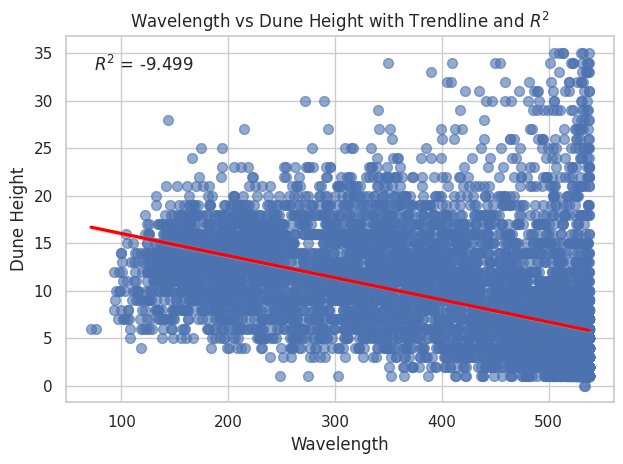

In [ ]:
#@title dune height vs wavelength


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score



# Print how many samples are used

df_subset = df_full[["dune_height", "pan_proximity_5k", "wavelength", "bullard_map"]].copy().dropna() #add wavelength_meas

#df_subset = df_subset[df_subset["bullard_map"] == 3]
print(f"Number of samples used for plot: {len(df_subset)}")
# drop wavelengths and dune heights
#df_subset = df_subset[df_subset["wavelength_meas"] <= 500]
df_subset = df_subset[df_subset["dune_height"] <= 35]


# Scatterplot with regression line
sns.set(style="whitegrid")
ax = sns.regplot(
    data=df_subset,
    x="wavelength",
    y="dune_height",
    scatter_kws={"s": 50, "alpha": 0.6},
    line_kws={"color": "red"}
)

# Compute R²
r2 = r2_score(df_subset["wavelength"], df_subset["dune_height"])

# Annotate R² on the plot
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top'
)

# Axis labels
plt.xlabel("Wavelength")
plt.ylabel("Dune Height")
plt.title("Wavelength vs Dune Height with Trendline and $R^2$")
plt.tight_layout()
plt.show()


Number of samples used for plot: 122
-2.3764577648225855


/tmp/ipython-input-16-1893034715.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


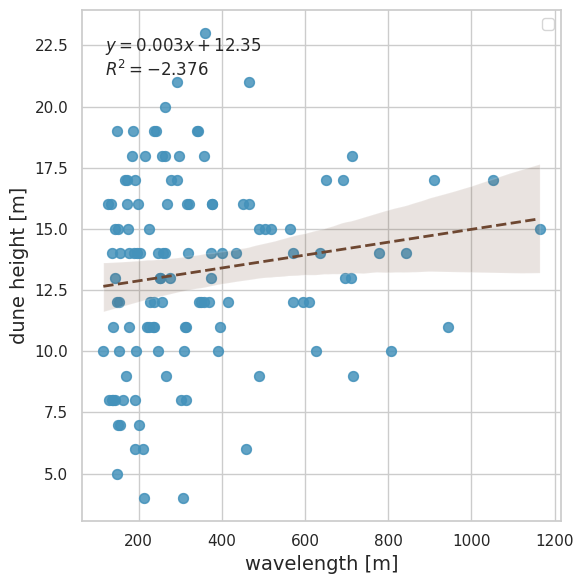

In [ ]:
#@title dune height vs wavelength NEWEST


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

variable_wavelength = "wavelength_meas"


# Custom colors
custom_colors = [
    "#6e4731",  # brown (for the identity line)
    "#a77a5d",
    "#d9b68a",
    "#d3d4ad",
    "#a0b1ae",
    "#4492bb"   # darkest blue (for the points)
]


# Print how many samples are used

df_subset = df_full[["dune_height", "pan_proximity_5k", variable_wavelength, "bullard_map"]].copy().dropna() #add wavelength_meas

#df_subset = df_subset[df_subset["bullard_map"] == 3]
print(f"Number of samples used for plot: {len(df_subset)}")
# drop wavelengths and dune heights
#df_subset = df_subset[df_subset["wavelength_meas"] <= 500]
df_subset = df_subset[df_subset["dune_height"] <= 35]


# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Scatterplot without regression line
plt.scatter(
    df_subset[variable_wavelength],
    df_subset["dune_height"],
    s=50,
    alpha=0.6,
    color=custom_colors[-1]  # darkest blue
)

# Scatterplot with regression line
sns.set(style="whitegrid")
ax = sns.regplot(
    data=df_subset,
    x=variable_wavelength,
    y="dune_height",
    color=custom_colors[-1],
    scatter_kws={"s": 50, "alpha": 0.6},
    line_kws={"color": custom_colors[0], "linestyle": "--", "linewidth": 2}
)


# Fit a linear regression model (degree 1 polynomial)
slope, intercept = np.polyfit(df_subset[variable_wavelength], df_subset["dune_height"], 1)

# Create regression equation string
equation = f"$y = {slope:.3f}x + {intercept:.2f}$"

# Compute R²
r2 = r2_score(df_subset[variable_wavelength], df_subset["dune_height"])
r2_text = f"$R^2 = {r2:.3f}$"

# Annotate both on the plot
plt.text(
    0.05, 0.95, f"{equation}\n{r2_text}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='left'
)



# Compute R²
r2 = r2_score(df_subset[variable_wavelength], df_subset["dune_height"])
print(r2)

# Optional: Annotate R² on the plot
# plt.text(
#     0.05, 0.95,
#     f"$R^2$ = {r2:.3f}",
#     transform=plt.gca().transAxes,
#     fontsize=12,
#     verticalalignment='top'
# )

#plt.ylim(top=600)
#plt.xlim(right=1200)

# Labels and title
plt.xlabel("wavelength [m]", fontsize=14)
plt.ylabel("dune height [m]", fontsize=14)
#plt.title("Wavelength [m]", fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()


Number of samples used for plot: 41


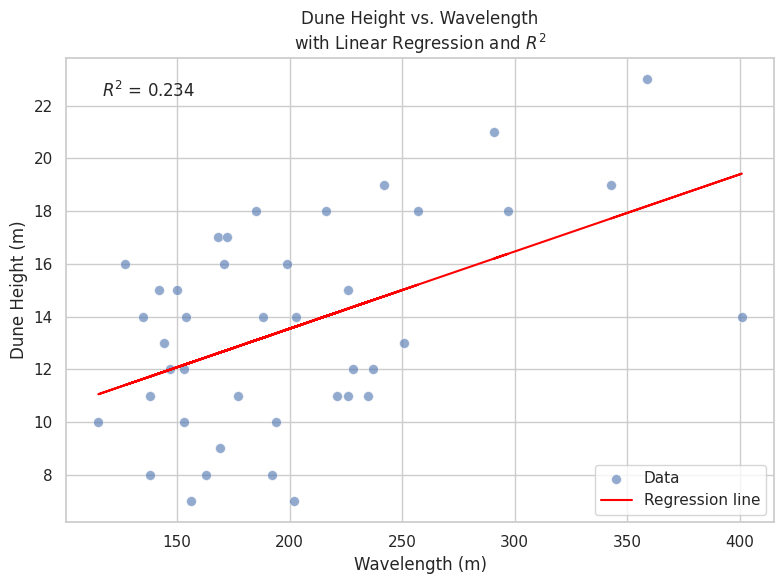

In [ ]:
#@title dune height vs wavelength NEW

#@title Dune Height vs Wavelength

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Subset and clean data
df_subset = df_full[["dune_height", "pan_proximity_5k", "wavelength_meas", "bullard_map"]].copy().dropna()

# Filter: only Bullard unit 3, and sensible dune height range
df_subset = df_subset[df_subset["bullard_map"] == 3]
#df_subset = df_subset[df_subset["pan_proximity_5k"] == 1]
df_subset = df_subset[df_subset["dune_height"] <= 35]
df_subset = df_subset[df_subset["wavelength_meas"] <= 500]

print(f"Number of samples used for plot: {len(df_subset)}")

# Prepare data for regression
X = df_subset["wavelength_meas"].values.reshape(-1, 1)
y = df_subset["dune_height"].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Compute R² score
r2 = r2_score(y, y_pred)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=df_subset,
    x="wavelength_meas",
    y="dune_height",
    s=50,
    alpha=0.6,
    label="Data"
)

# Plot regression line
plt.plot(df_subset["wavelength_meas"], y_pred, color="red", label="Regression line")

# Annotate R²
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top'
)

# Labels and title
plt.xlabel("Wavelength (m)")
plt.ylabel("Dune Height (m)")
plt.title("Dune Height vs. Wavelength\nwith Linear Regression and $R^2$")
plt.legend()
plt.tight_layout()
plt.show()


Number of samples used: 41
Fitted power-law parameters: c = 1.323, n = 0.434


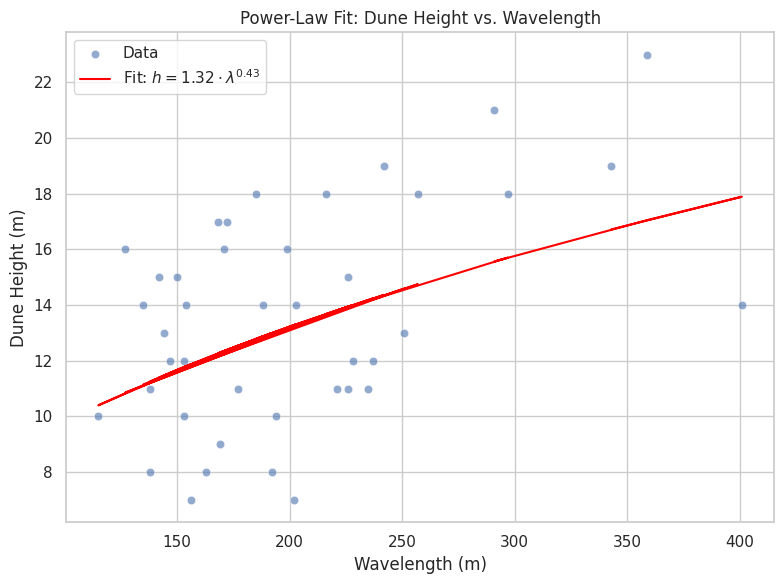

In [ ]:
#@title dune height wavelength power law fit

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Filter data
df_subset = df_full[["dune_height", "wavelength_meas", "bullard_map"]].copy().dropna()
df_subset = df_subset[df_subset["bullard_map"] == 3]
df_subset = df_subset[df_subset["dune_height"] <= 35]
df_subset = df_subset[(df_subset["dune_height"] > 0) & (df_subset["wavelength_meas"] > 0)]  # log-safe

print(f"Number of samples used: {len(df_subset)}")

# Log-transform
X_log = np.log(df_subset["wavelength_meas"].values).reshape(-1, 1)
y_log = np.log(df_subset["dune_height"].values)

# Fit linear regression in log-log space
model = LinearRegression()
model.fit(X_log, y_log)

n = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)

print(f"Fitted power-law parameters: c = {c:.3f}, n = {n:.3f}")

# Predicted values (for plotting)
wavelength_vals = df_subset["wavelength_meas"].values
dune_height_pred = c * (wavelength_vals ** n)

# Plot original data and power-law curve
plt.figure(figsize=(8, 6))
sns.scatterplot(x="wavelength_meas", y="dune_height", data=df_subset, alpha=0.6, label="Data")
plt.plot(wavelength_vals, dune_height_pred, color='red', label=f"Fit: $h = {c:.2f} \cdot \\lambda^{{{n:.2f}}}$")

plt.xlabel("Wavelength (m)")
plt.ylabel("Dune Height (m)")
plt.title("Power-Law Fit: Dune Height vs. Wavelength")
plt.legend()
plt.tight_layout()
plt.show()


Number of samples used for plot: 12
R² score: 0.457
Mean Absolute Error (MAE): 2.333


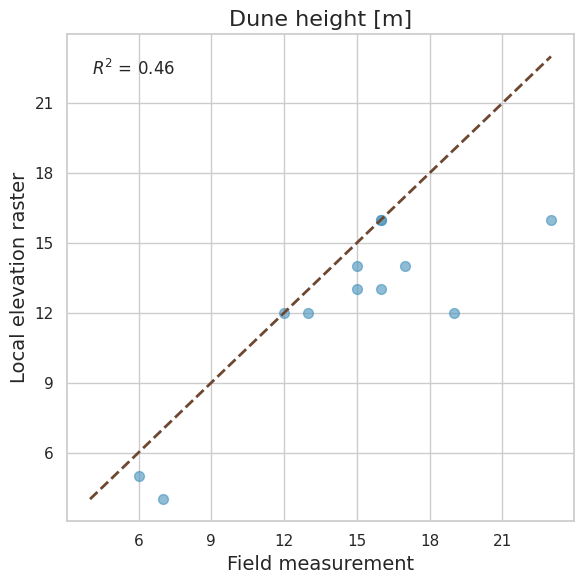

In [ ]:
#@title dune height measured vs modelled

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# === Load your CSV ===
csv_path = "/content/drive/My Drive/PAPER3_data/analysis/field_work_dune_height.csv"  # Replace with your actual file path
df_full = pd.read_csv(csv_path)

# === Column names (replace if needed) ===
x_col = "measured"
y_col = "modelled"

# === Clean the DataFrame ===
df_subset = df_full[[x_col, y_col]].copy().dropna()

# === Check how many samples are used ===
print(f"Number of samples used for plot: {len(df_subset)}")

# === Custom colors ===
custom_colors = [
    "#6e4731",  # brown (identity line)
    "#a77a5d",
    "#d9b68a",
    "#d3d4ad",
    "#a0b1ae",
    "#4492bb"   # blue (scatter points)
]

# === Set style and create figure ===
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# === Scatterplot ===
plt.scatter(
    df_subset[x_col],
    df_subset[y_col],
    s=50,
    alpha=0.6,
    color=custom_colors[-1],  # blue
    label="Predictions"
)

# === Identity line ===
min_val = min(df_subset[x_col].min(), df_subset[y_col].min())
max_val = max(df_subset[x_col].max(), df_subset[y_col].max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color=custom_colors[0],  # brown
    linestyle="--",
    linewidth=2,
    label="Identity line"
)

# === R² score ===
r2 = r2_score(df_subset[x_col], df_subset[y_col])
print(f"R² score: {r2:.3f}")

# Optional: Add R² annotation
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

# === Absolute error ===
df_subset["abs_error"] = (df_subset[y_col] - df_subset[x_col]).abs()
mae = df_subset["abs_error"].mean()
print(f"Mean Absolute Error (MAE): {mae:.3f}")

# Force integer ticks
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))


# === Labels and formatting ===
plt.xlabel("Field measurement", fontsize=14)
plt.ylabel("Local elevation raster", fontsize=14)
plt.title("Dune height [m]", fontsize=16)
#plt.legend()
plt.tight_layout()
plt.show()


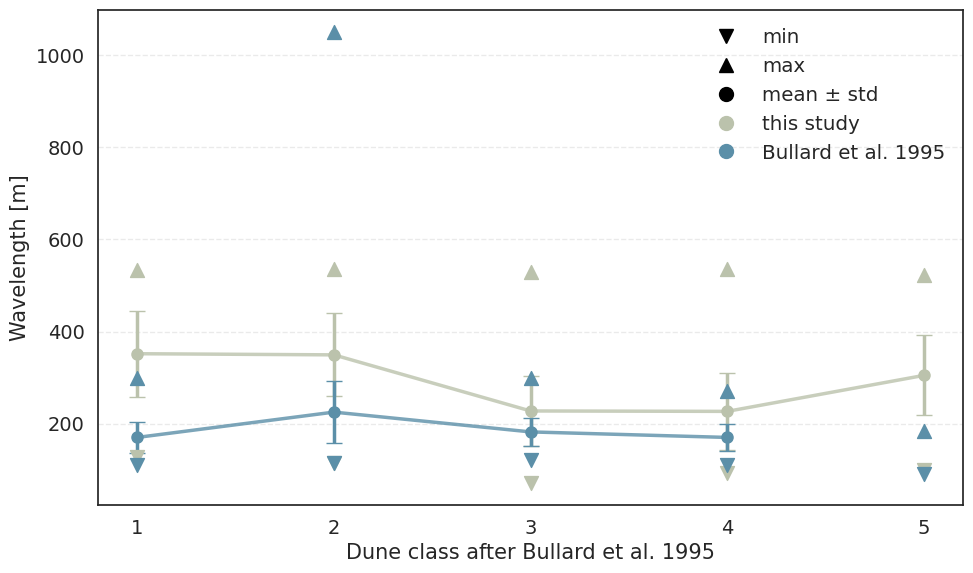

In [ ]:
#@title boxplot wavelength vs bullard class


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple


# Class labels
bullard_labels = {1: "1", 2: "2", 3: "3", 4: "4", 5: "5"}

# Filter your data
plot_df = df[
    (df["bullard_map"].notna()) &
    (df["bullard_map"] != 0) &
    (df["wavelength"].notna())
].copy()

plot_df["bullard_map"] = plot_df["bullard_map"].astype(int)
plot_df = plot_df[plot_df["bullard_map"].isin(bullard_labels.keys())]

sorted_classes = sorted(bullard_labels.keys())
x = np.arange(len(sorted_classes))

# Your stats
your_stats = plot_df.groupby("bullard_map")["wavelength"].agg(['mean', 'std', 'min', 'max']).reindex(sorted_classes)

# Bullard data
original_stats = pd.DataFrame({
    1: {"mean": 170, "std": 33.31, "min": 110, "max": 300},
    2: {"mean": 225, "std": 68.1, "min": 115, "max": 1050},
    3: {"mean": 182, "std": 30.17, "min": 120, "max": 300},
    4: {"mean": 170, "std": 28.93, "min": 110, "max": 270},
    5: {"mean": 36, "std": 29.21, "min": 90, "max": 185},
}).T.reindex(sorted_classes)

original_stats.loc[5, ['mean', 'std']] = np.nan

# Offsets for side-by-side points
offset = 0
x_your = x - offset
x_bullard = x + offset

# Colors
your_color = "#bbc2ac"
bullard_color = "#5b8fa8"
marker_size = 100
line_width = 2.5

plt.figure(figsize=(10, 6))

# Plot YOUR data
plt.errorbar(x_your, your_stats['mean'], yerr=your_stats['std'],
             fmt='o', color=your_color, capsize=6, elinewidth=line_width,
             markersize=8, label='mean ± std')
plt.scatter(x_your, your_stats['min'], color=your_color, marker='v', s=marker_size, label='Your Min', zorder=3)
plt.scatter(x_your, your_stats['max'], color=your_color, marker='^', s=marker_size, label='Your Max', zorder=3)

# Plot Bullard data
plt.errorbar(x_bullard, original_stats['mean'], yerr=original_stats['std'],
             fmt='o', color=bullard_color, capsize=6, elinewidth=line_width,
             markersize=8, label='Bullard Mean ± Std')
plt.scatter(x_bullard, original_stats['min'], color=bullard_color, marker='v', s=marker_size, label='Bullard Min', zorder=3)
plt.scatter(x_bullard, original_stats['max'], color=bullard_color, marker='^', s=marker_size, label='Bullard Max', zorder=3)

# 💡 Add lines through means
plt.plot(x_your, your_stats['mean'], color=your_color, linewidth=line_width, linestyle='-', alpha=0.8)
plt.plot(x_bullard, original_stats['mean'], color=bullard_color, linewidth=line_width, linestyle='-', alpha=0.8)

# Axis formatting
plt.xticks(ticks=x, labels=[bullard_labels[i] for i in sorted_classes], fontsize=14)
plt.xlabel("Dune class after Bullard et al. 1995", fontsize=15)
plt.ylabel("Wavelength [m]", fontsize=15)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Black markers for min, max, and mean+std (dot only, no line)
legend_min = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='min')
legend_max = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='max')
legend_mean_std = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='mean ± std')

# Color dots for your data and Bullard data (no line)
your_dot = mlines.Line2D([], [], color='#bbc2ac', marker='o', linestyle='None', markersize=10, label='this study')
bullard_dot = mlines.Line2D([], [], color='#5b8fa8', marker='o', linestyle='None', markersize=10, label='Bullard et al. 1995')

plt.legend(
    handles=[legend_min, legend_max, legend_mean_std, your_dot, bullard_dot],
    loc='best',
    frameon=False  # optional, makes legend cleaner
)

plt.tight_layout()
plt.show()




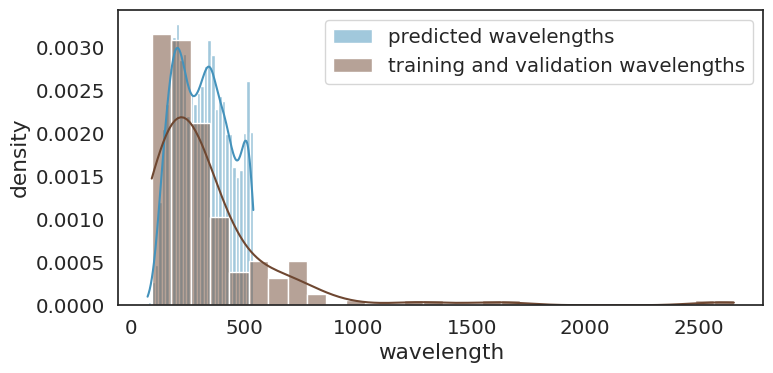

In [ ]:
#@title histograms wavelength

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load second dataset
file_path = '/content/drive/My Drive/PARDUNE_data/kalahari/metrics_stats/train_label_morphometrics_class_bullard1995_metrics_only.csv'
df_external = pd.read_csv(file_path)

# Optional: drop NaNs in advance
wavelength_1 = df["wavelength"].dropna()
wavelength_2 = df_external["wavelength"].dropna()

# Plot both histograms
plt.figure(figsize=(8, 4))
sns.histplot(wavelength_1, kde=True, bins=30, color="#4492bb", label="predicted wavelengths", stat="density", alpha=0.5)
sns.histplot(wavelength_2, kde=True, bins=30, color="#6e4731", label="training and validation wavelengths", stat="density", alpha=0.5)

plt.xlabel("wavelength")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
bla = df["wavelength"].unique()
print(bla.max())

537.570068359375
